Efficient Triple Attention and AttentionMix: A Novel Network
for Fine-Grained Crop Disease Classification


In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import cv2

# ==============================
# 1. DATASET PREPARATION
# ==============================
def create_dataloaders(data_dir, batch_size=16, train_ratio=0.8):
    """
    Loads images from a directory where each subfolder represents a class.
    Splits into train/test sets dynamically.
    """
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  
        transforms.RandomCrop((448, 448)),  
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    
    train_set, test_set = random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, test_loader, dataset.classes

# ==============================
# 2. EFFICIENT TRIPLE ATTENTION (ETA) MODULE
# ==============================
class EfficientTripleAttention(nn.Module):
    """
    ETA Module: Enhances feature representation by capturing cross-dimensional relationships.
    Fix: Adjusts Conv1D inputs for proper processing.
    """
    def __init__(self, channels):
        super(EfficientTripleAttention, self).__init__()

        # 1D convolutions for channel-wise attention
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=1, groups=channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=1, groups=channels)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=1, groups=channels)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Ensure input is at least 3D for Conv1D
        if x.dim() == 4:  # (B, C, H, W) -> (B, C, 1, 1)
            x = x.squeeze(-1).squeeze(-1)  # (B, C)
        
        x = x.unsqueeze(-1)  # (B, C, 1) for Conv1D
        
        x_hc = self.conv1(x)
        x_wc = self.conv2(x)
        x_hw = self.conv3(x)

        attention = self.sigmoid(x_hc + x_wc + x_hw)
        return x * attention  # (B, C, 1)

# ==============================
# 3. ATTENTIONMIX DATA AUGMENTATION
# ==============================
class AttentionMix:
    """
    Data Augmentation: Mixes images based on attention maps instead of random cuts.
    """
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    def __call__(self, img_batch):
        batch_size = img_batch.size(0)
        mixed_images = torch.zeros_like(img_batch)

        for i in range(batch_size):
            img1 = img_batch[i]  # Single image (C, H, W)
            img2 = img_batch[random.randint(0, batch_size - 1)]  # Another random image

            lam = np.random.beta(self.alpha, self.alpha)

            # Convert to NumPy for OpenCV operations
            img1_np = img1.permute(1, 2, 0).cpu().numpy() * 255
            img2_np = img2.permute(1, 2, 0).cpu().numpy() * 255

            # Convert to grayscale and threshold to get important regions
            gray = cv2.cvtColor(img1_np.astype(np.uint8), cv2.COLOR_RGB2GRAY)
            _, mask = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
            mask = mask / 255.0  # Normalize mask

            # Blend images based on the attention mask
            img_mixed = img1_np * mask[:, :, None] + img2_np * (1 - mask[:, :, None])
            img_mixed = torch.tensor(img_mixed / 255).permute(2, 0, 1).float()

            # Store in batch
            mixed_images[i] = lam * img1 + (1 - lam) * img_mixed

        return mixed_images


# ==============================
# 4. MODEL ARCHITECTURE (ResNet50 + ETA)
# ==============================
class CropDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(CropDiseaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove last classification layer
        self.eta = EfficientTripleAttention(channels=2048)  # Apply ETA module
        self.fc = nn.Linear(2048, num_classes)  # Custom classifier

    def forward(self, x):
        x = self.backbone(x)  # ResNet-50 output is (B, 2048)
        x = self.eta(x)  # Apply ETA (now correctly handling shape)
        x = x.view(x.size(0), -1)  # Flatten for classifier
        x = self.fc(x)  # Final classification
        return x

# ==============================
# 5. TRAINING FUNCTION (Using Exact Paper Settings)
# ==============================
def train(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)  # Decay LR every 2 epochs

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Apply AttentionMix Augmentation
            mixed_images = AttentionMix()(images)

            optimizer.zero_grad()
            outputs = model(mixed_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()  # Apply learning rate decay

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")




In [2]:
# ==============================
# 6. RUN THE TRAINING
# ==============================
if __name__ == "__main__":
    data_path = "./D3_Final/"  # Replace with the dataset folder
    train_loader, test_loader, classes = create_dataloaders(data_path, batch_size=16)
    
    model = CropDiseaseModel(num_classes=len(classes))
    train(model, train_loader, epochs=10, lr=0.001)


c:\Users\DELL\intelpython3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\intelpython3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.9343
Epoch [2/10], Loss: 0.5267
Epoch [3/10], Loss: 0.4147
Epoch [4/10], Loss: 0.3224
Epoch [5/10], Loss: 0.2754
Epoch [6/10], Loss: 0.2469
Epoch [7/10], Loss: 0.2155
Epoch [8/10], Loss: 0.1915
Epoch [9/10], Loss: 0.2039
Epoch [10/10], Loss: 0.1884


Test Accuracy: 99.05%


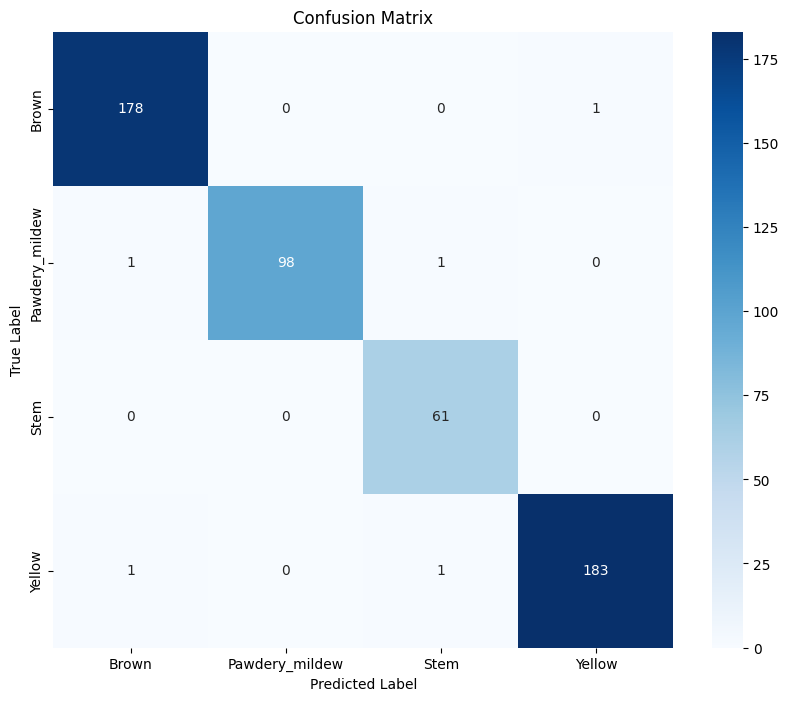

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# ==============================
# TESTING FUNCTION
# ==============================
def test(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Get predictions
            _, preds = torch.max(outputs, 1)  # Get class with highest probability

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm, accuracy

# ==============================
# PLOT CONFUSION MATRIX
# ==============================
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ==============================
# RUN TESTING
# ==============================
if __name__ == "__main__":
    cm, test_accuracy = test(model, test_loader)
    plot_confusion_matrix(cm, classes)


In [5]:
torch.save(model.state_dict(), "M3.pth")
print("Modèle sauvegardé sous 'M3.pth'")

Modèle sauvegardé sous 'M3.pth'


In [6]:
if __name__ == "__main__":
    data_path = "./D3_Final/"  # Replace with the dataset folder
    train_loader, test_loader, classes = create_dataloaders(data_path, batch_size=16)
    

In [12]:
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models

# Charger le modèle entraîné
model = CropDiseaseModel(num_classes=len(classes))  # Assurez-vous que 'classes' est défini
model.load_state_dict(torch.load("M3.pth", map_location=torch.device("cpu")))
model.eval()

# Transformer l'image pour le modèle
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.CenterCrop((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Charger l'image de test
image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Ajouter une dimension batch

# Passer l'image à travers le modèle
output = model(input_tensor)
_, predicted_class = torch.max(output, 1)
print(f"Classe prédite : {classes[predicted_class.item()]}")


Classe prédite : Pawdery_mildew


c:\Users\DELL\intelpython3\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


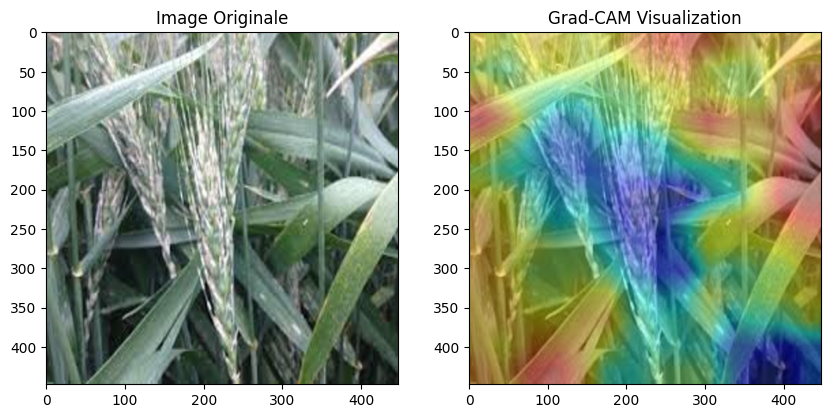

In [9]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook pour capturer les gradients
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activation_maps = output  # Sauvegarde des activations

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Sauvegarde des gradients

    def generate_heatmap(self, input_tensor, target_class):
        # Faire une passe avant
        output = self.model(input_tensor)
        self.model.zero_grad()

        # Calculer le gradient de la classe cible
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Moyenne des gradients
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        heatmap = torch.sum(weights * self.activation_maps, dim=1).squeeze()

        # Appliquer ReLU et normaliser
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()

# Sélectionner la dernière couche de convolution du modèle
target_layer = model.backbone.layer4[-1]  # Dernière couche convolutive de ResNet50
grad_cam = GradCAM(model, target_layer)

# Générer la carte de chaleur Grad-CAM
heatmap = grad_cam.generate_heatmap(input_tensor, predicted_class.item())

# Superposer sur l'image originale
heatmap = cv2.resize(heatmap, (448, 448))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convertir l'image originale en NumPy
image_np = np.array(image.resize((448, 448)))
superimposed_img = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

# Afficher les résultats
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image Originale")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM Visualization")

plt.show()
